In [9]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count
from tqdm.notebook import tqdm
import gc
import os
import sys
import joblib
submit_kaggle = True

In [10]:
%%time
cols_to_load = ['user_id', 'answered_correctly', 'content_id', 'prior_question_had_explanation', 'prior_question_elapsed_time']
FEATURES = pd.read_pickle('../input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip')[cols_to_load]
FEATURES['prior_question_had_explanation'] = FEATURES['prior_question_had_explanation'].astype('boolean')

# questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')
# lectures = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv')
dtype={'num_user_answered_questions':np.int16, 
       'num_user_correctly_questions':np.int16, 
       'mean_user_accuracy':np.float32,
       'watches_lecture':'boolean',
       'part':np.int8,
       'content_questions':np.int32,
       'mean_content_accuracy':np.float32,
       'mean_prior_question_had_explanation':np.float32,
       'mean_prior_question_elapsed_time':np.float32,
       'mean_user_question_elapsed_time':np.float32,
       'mean_user_question_had_explanation':np.float32
      }
user_df = pd.read_csv('../data/user_df.csv', index_col=0,dtype=dtype)
content_df = pd.read_csv('../data/content_df.csv', index_col=0,dtype=dtype)

CPU times: user 11.1 s, sys: 2.49 s, total: 13.6 s
Wall time: 14 s


In [11]:
%%time
FEATURES = FEATURES[FEATURES['answered_correctly'] != -1]
FEATURES['answered_user'] = FEATURES[['user_id','content_id']].groupby('user_id').cumcount().astype(np.uint16)
FEATURES['answered_correctly_user'] = FEATURES[['answered_correctly', 'user_id']].groupby('user_id').cumsum().astype(np.uint16)
FEATURES['answered_correctly_user'] = FEATURES[['answered_correctly_user', 'user_id']].groupby('user_id').shift(1)
FEATURES['answered_correctly_user'] = FEATURES['answered_correctly_user'].fillna(0)
FEATURES['answered_correctly_user'] = FEATURES['answered_correctly_user'].astype(np.uint16)
FEATURES['attempt'] = FEATURES.groupby(['user_id', 'content_id']).content_id.transform('cumcount').astype(np.uint8)

CPU times: user 30.3 s, sys: 6.44 s, total: 36.7 s
Wall time: 36.7 s


In [12]:
def make_features(FEATURES):
    # merge with all features
    FEATURES = FEATURES.merge(user_df, how="left", on="user_id")
    FEATURES = FEATURES.merge(content_df, how='left', on='content_id')
    # add harmonic mean
    FEATURES['hmean_user_content_accuracy'] = 2 * (
        (FEATURES['mean_user_accuracy'] * FEATURES['mean_content_accuracy']) /
        (FEATURES['mean_user_accuracy'] + FEATURES['mean_content_accuracy'])
    )
    FEATURES['question_elapsed_time'] = FEATURES['prior_question_elapsed_time'].shift(-1)
    FEATURES['question_elapsed_time'] = FEATURES['question_elapsed_time'].fillna(FEATURES['mean_user_question_elapsed_time'])
    FEATURES['question_elapsed_standard'] = (FEATURES['question_elapsed_time']/FEATURES['mean_prior_question_elapsed_time']).astype('float32')
    for c in categorical_feature:
        FEATURES[c] = FEATURES[c].astype('category')
    return FEATURES

In [13]:
%%time

categorical_feature = [
                     'part',
                     ]
features =[
 'mean_user_accuracy',
 'answered_correctly_user',
 'answered_user',
 'mean_content_accuracy',
 'part',
 'question_elapsed_standard',
 'hmean_user_content_accuracy',
 'attempt']
target = 'answered_correctly'

FEATURES = make_features(FEATURES)
col = features + [target]
FEATURES = FEATURES[col]
FEATURES.dtypes

CPU times: user 22.7 s, sys: 6.48 s, total: 29.2 s
Wall time: 29.2 s


mean_user_accuracy              float32
answered_correctly_user          uint16
answered_user                    uint16
mean_content_accuracy           float32
part                           category
question_elapsed_standard       float32
hmean_user_content_accuracy     float32
attempt                           uint8
answered_correctly                 int8
dtype: object

In [14]:
%%time
if submit_kaggle:
    lgb_train = lgb.Dataset(FEATURES[features], FEATURES[target], categorical_feature = categorical_feature)
    del FEATURES
    gc.collect()
else:
    X_train, X_valid, y_train, y_valid = train_test_split(FEATURES[features], FEATURES[target], test_size=0.2, random_state=1)
    del FEATURES
    gc.collect()
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = categorical_feature)
    lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature = categorical_feature)
    del X_train, y_train, X_valid, y_valid
    gc.collect()

CPU times: user 589 ms, sys: 176 ms, total: 765 ms
Wall time: 763 ms


In [15]:
params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 1,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt" #default
         }
METRICS = ['auc']

In [17]:
evals_result = {}
if submit_kaggle:
    model = lgb.train(
        params = params, 
        train_set = lgb_train,
        valid_sets = lgb_train,
        verbose_eval = 50,
        num_boost_round = 300,
        early_stopping_rounds = 10,
        categorical_feature = categorical_feature,
        feature_name = features,
        evals_result = evals_result,
    )
else:
    model = lgb.train(
        params = params, 
        train_set = lgb_train,
        valid_sets = [lgb_train,lgb_eval],
        verbose_eval = 50,
        num_boost_round = 300,
        early_stopping_rounds = 10,
        categorical_feature = categorical_feature,
        feature_name = features,
        evals_result = evals_result,
    )

[LightGBM] [Info] Number of positive: 65244627, number of negative: 34026673
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.424975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1559
[LightGBM] [Info] Number of data points in the train set: 99271300, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657236 -> initscore=0.650999
[LightGBM] [Info] Start training from score 0.650999
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.773397
[100]	training's auc: 0.774934
[150]	training's auc: 0.775559
[200]	training's auc: 0.775916
[250]	training's auc: 0.77621
[300]	training's auc: 0.776454
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.776454


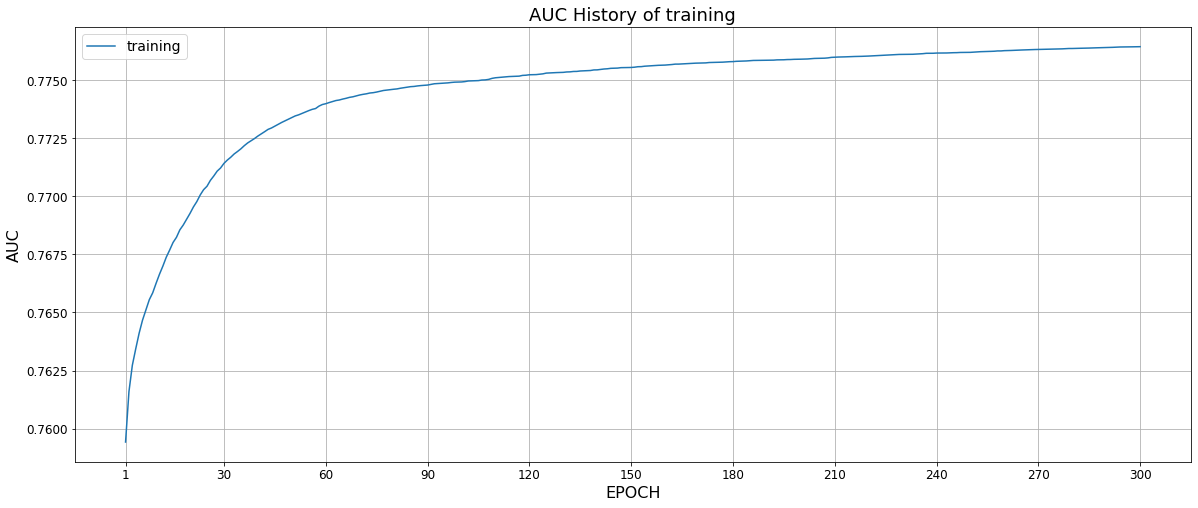

In [18]:
def plot_history(evals_result):
    for metric in METRICS:
        plt.figure(figsize=(20,8))
        
        for key in evals_result.keys():
            history_len = len(evals_result.get(key)[metric])
            history = evals_result.get(key)[metric]
            x_axis = np.arange(1, history_len + 1)
            plt.plot(x_axis, history, label=key)
        
        x_ticks = list(filter(lambda e: (e % (history_len // 100 * 10) == 0) or e == 1, x_axis))
        plt.xticks(x_ticks, fontsize=12)
        plt.yticks(fontsize=12)

        plt.title(f'{metric.upper()} History of training', fontsize=18);
        plt.xlabel('EPOCH', fontsize=16)
        plt.ylabel(metric.upper(), fontsize=16)
        
        if metric in ['auc']:
            plt.legend(loc='upper left', fontsize=14)
        else:
            plt.legend(loc='upper right', fontsize=14)
        plt.grid()
        plt.show()

plot_history(evals_result)

In [ ]:
lgb.plot_importance(model)
plt.show()

In [ ]:
joblib.dump(model, '../input/data_io/state2_3.pkl')

---

# Predict

In [ ]:
# model = joblib.load('../input/data_io/model_Riiid_Competition_Baseline_1.pkl')

In [2]:
!git add ../data
!git commit -m "add state2_3.pkl"
!git add ../working
!git commit -m "add state2_3.pkl"
!git push

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    V2_state_0.698.ipynb
	modified:   import_riiid_raw_data.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	V2_state_0.753.ipynb
	riiid-train-data-multiple-formats.zip

no changes added to commit (use "git add" and/or "git commit -a")
^C
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    V2_state_0.698.ipynb
	modified:   import_riiid_raw_data.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	V2_state_0.753.ipynb
	riiid-train-data-multiple-formats.zip

no changes added to commit (use "